In [12]:
%pip install xlrd

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
from scipy.linalg import solve_sylvester, norm
import os
from sklearn.metrics import f1_score
import json
import pandas as pd
from enum import Enum

Data generation

In [14]:
class MatrixType(Enum):
    """
    Enum representing different available matrices in the data directory
    """
    SCALE_FREE = "Scale_Free_Laplacian"
    ERDOS_RENYI = "Erdos_Renyi_Laplacian"
    SMALL_WORLD = "Small_World_Laplacian"
    GRID_GRAPH = "Grid_Graph_Laplacian"
    BUS_33_MODIFIED = "33bus_modified_ybus"
    WATER_NETWORK = "water_network"

In [20]:
def load_B(matrix_type: MatrixType, data_dir='Data'):
    """
    Load a specific matrix from Data directory
    """
    matrix_name = matrix_type.value
    file_path = os.path.join(data_dir, matrix_name + '.csv')
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Matrix file '{matrix_name}' not found in {data_dir}.")

    B = pd.read_csv(file_path, header=None).values  # Into a Numpy array

    return B

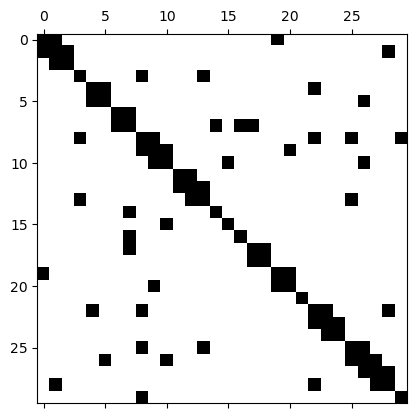

In [27]:
plt.spy(load_B(matrix_type=MatrixType.ERDOS_RENYI))

In [28]:
def generate_sparse_covariance(B, sample_scaling=1.0):
    """
    Generate a sparse inverse covariance matrix B, compute its associated covariance matrix E,
    and generate samples from a multivariate normal distribution with covariance E.

    Parameters:
    - n (int): Dimension of the matrix.
    - sample_scaling (float): Scaling factor for the number of samples (N = sample_scaling * d^2 log2(n)).
    - random_state (int): Random seed for reproducibility.

    Returns:
    - S (np.ndarray): Sample covariance matrix from the generated samples.
    - N (int): Computed number of samples.
    """

    n = len(B)

    # Compute degree d as the maximum number of nonzero entries per row in B (excluding diagonal)
    d = np.max(np.sum(B != 0, axis=1)) - 1  # Exclude diagonal elements
    print("Max degree in B", d)

    # Compute the required number of samples with log 
    N = int(sample_scaling * ((d*d) * np.log(n)))

    # Compute true inverse covariance matrix (Strue)
    Strue = np.linalg.matrix_power(B, 2)

    # Compute covariance matrix (E)
    E = np.linalg.inv(Strue)

    # Generate N samples Y ~ N(0, E)
    y_samples = la.sqrtm(E).dot(np.random.randn(n, N))

    # Calculate sample covariance matrix
    S = np.cov(y_samples)

    return S, N

Max degree in B 5
Number of samples 85
F1 norm 36.76598856725062


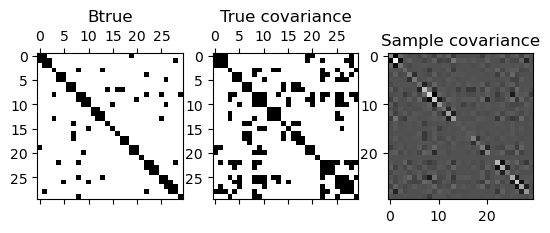

In [63]:
B = load_B(MatrixType.ERDOS_RENYI)
S, N = generate_sparse_covariance(B, sample_scaling=1)
plt.subplot(1,3, 1)
plt.spy(B)
plt.title("Btrue")
plt.subplot(1,3,2)
plt.spy(B@B)
plt.title("True covariance")
plt.subplot(1,3,3)
plt.imshow(np.linalg.inv(S), cmap = 'gray')
plt.title("Sample covariance")
print("Number of samples", N)
print("F1 norm", np.linalg.norm(np.linalg.inv(B@B)-S, ord="fro"))

Algorithm

In [41]:
def newton_nare(A, B, C, D, X0, tol=1e-13, kmax=30):
    """
    Newton's method for solving the Nonlinear Algebraic Riccati Equation (NARE):
    C + XA + DX - XBX = 0
    """
    X = X0.copy()
    k = 0
    err = 1

    while err > tol and k < kmax:
        # Compute residual RX = C + XA + DX - XBX
        RX = C + X @ A + D @ X - X @ B @ X

        # Solve the Sylvester equation (D - XB)H + H(A - BX) = -RX for H
        H = solve_sylvester(D - X @ B, A - B @ X, -RX)

        # Update X
        X = X + H

        # Calculate the error; changed from l1 to frobenius
        err = norm(H, 1) / norm(X, 1)
        # err = norm(H, 'fro') / (1 + norm(X, 'fro'))

        if k % 5 == 0:  # Print every 5 iterations
            print(f"Iteration {k}, Error: {err:.2e}")
        
        # Increment iteration counter
        k += 1

    # Check if the solution converged
    if k == kmax:
        print("Warning: reached the maximum number of iterations without convergence.")

    return X

In [42]:
# Soft thresholding function
def soft_thresholding(x, threshold):
    """Applies soft-thresholding elementwise."""
    return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

In [43]:
def soft_thresholding_offdiag(B_new, Lambda, lambda_, rho):
    """
    Applies off-diagonal soft-thresholding.
    """
    
    # Compute argument for soft-thresholding
    X = rho * B_new + Lambda
    
    # Create a copy to modify
    Z_new = X.copy()
    
    # Off-diagonal mask
    mask_offdiag = ~np.eye(X.shape[0], dtype=bool)

    # Apply soft-thresholding only to off-diagonal elements
    Z_new[mask_offdiag] = np.sign(X[mask_offdiag]) * np.maximum(np.abs(X[mask_offdiag]) - lambda_, 0)

    return Z_new


In [64]:
# ADMM Algorithm for Elastic-Net Penalized Precision Matrix Estimation
def admm_precision_matrix(S, lambda_, rho=1.0, max_iter=100, tol=1e-4):
    """
    ADMM algorithm for precision matrix estimation with elastic-net penalty.
    """
    n = S.shape[0]
    Z = np.zeros((n, n))
    Lambda = np.zeros((n, n))
    I = np.eye(n)  # Identity matrix

    # Initial B (can be initialized as identity matrix)
    B = np.eye(n)

    for k in range(max_iter):
        # Step 1: Update B using Newton NARE
        # Here, we set up the matrices to solve the NARE: A3 + XA1 + A4X - XA2X = 0
        A3 = - 2 * I
        A4 = Lambda - rho * Z
        A1 = 0 * I
        A2 = - (2 * S + rho * I)
        X0 = B  # Initial guess for Newton NARE

        # Solve for the new B using Newton NARE
        B_new = newton_nare(A1, A2, A3, A4, X0)

        # Step 2: Update Z elementwise using soft-thresholding
        Z_new = soft_thresholding(rho * B_new + Lambda, lambda_)
        Z_new = Z_new / rho

        # Step 3: Update Lambda (Lagrange multiplier)
        Lambda_new = Lambda + rho * (B_new - Z_new)

        # print(f"ADMM update loss: ", np.linalg.norm(B_new - B, ord='fro') )
        # Check convergence
        if np.linalg.norm(B_new - B, ord='fro') < tol:
            print(f"ADMM Converged after {k+1} iterations.")
            break
        elif k == max_iter-1 :
            print(f"ADMM failed to converge after {k+1} iterations.")

        # Update for the next iteration
        B, Z, Lambda = B_new, Z_new, Lambda_new      

    return B

In [55]:
#Thresholding B_estimate
def hard_threshold(B_estimate,threshold):
  return np.where(np.abs(B_estimate) > threshold, B_estimate, 0)

Simple experiment

In [46]:
B = load_B(matrix_type=MatrixType.ERDOS_RENYI)

In [65]:
S, N = generate_sparse_covariance(B, sample_scaling=1.0)
# Parameters for the elastic-net penalty and ADMM algorithm
lambda_ = 0.166  # Regularization strength
alpha = 1  # Mixing parameter (0 = Ridge, 1 = Lasso)
rho = 1.0  # ADMM penalty parameter
max_iter = 200  # Maximum number of iterations
tol = 1e-4  # Convergence tolerance

# Run the ADMM algorithm using the generated sample covariance matrix
B_estimate = admm_precision_matrix(S, lambda_, rho, max_iter, tol)

print("Estimated Precision Matrix (B estimate):")
print(B_estimate)

Max degree in B 5
Iteration 0, Error: 5.35e-01
Iteration 5, Error: 3.30e-04
Iteration 0, Error: 2.06e-01
Iteration 0, Error: 3.20e-01
Iteration 5, Error: 4.38e-15
Iteration 0, Error: 2.17e-01
Iteration 0, Error: 1.23e-01
Iteration 0, Error: 8.12e-02
Iteration 0, Error: 5.70e-02
Iteration 0, Error: 4.35e-02
Iteration 0, Error: 3.08e-02
Iteration 0, Error: 2.16e-02
Iteration 0, Error: 1.51e-02
Iteration 0, Error: 1.09e-02
Iteration 0, Error: 7.14e-03
Iteration 0, Error: 5.42e-03
Iteration 0, Error: 4.41e-03
Iteration 0, Error: 3.64e-03
Iteration 0, Error: 2.64e-03
Iteration 0, Error: 1.98e-03
Iteration 0, Error: 2.33e-03
Iteration 0, Error: 1.71e-03
Iteration 0, Error: 1.82e-03
Iteration 0, Error: 1.61e-03
Iteration 0, Error: 1.20e-03
Iteration 0, Error: 1.30e-03
Iteration 0, Error: 1.27e-03
Iteration 0, Error: 1.15e-03
Iteration 0, Error: 8.80e-04
Iteration 0, Error: 6.99e-04
Iteration 0, Error: 6.36e-04
Iteration 0, Error: 5.93e-04
Iteration 0, Error: 5.32e-04
Iteration 0, Error: 6.36e

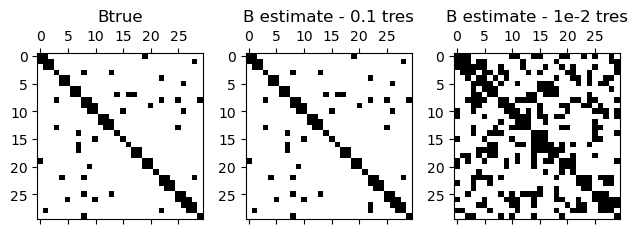

In [66]:
plt.subplot(1,3, 1)
plt.spy(B)
plt.title("Btrue")
plt.subplot(1,3,2)
# plt.imshow(hard_threshold(B_estimate, 0.2), cmap= "gray")
plt.spy(hard_threshold(B_estimate, 0.1))
plt.title("B estimate - 0.1 tres")
plt.subplot(1,3,3)
# plt.imshow(hard_threshold(B_estimate, 0.4), cmap= "gray")
plt.spy(hard_threshold(B_estimate, 1e-2))
plt.tight_layout()
plt.title("B estimate - 1e-2 tres")
plt.show()

Experimentation

In [68]:
def evaluate_f1_vs_lambda(
        lambda_values, B, sample_scaling=1.0,
        rho=1.0, max_iter=100, tol=1e-4,
        threshold=1e-4, save_plots = False, log_dir="experiment_logs"):
    """
    Evaluate f1 scores, 
    excluding diagonal elements, for each lambda.
    """
    
    B = np.array(B)
    n = B.shape[0]
    
    # Generate sample covariance S and sample size N
    S, N = generate_sparse_covariance(B, sample_scaling=sample_scaling)

    print("Number of samples:", N)
    print("Minimum eigenvalue of B:", np.min(np.linalg.eigvals(B)))

    # Ground-truth adjacency (full)
    ground_truth_adjacency = (B != 0).astype(int)

    # Exclude diagonals via a mask
    mask_offdiag = ~np.eye(n, dtype=bool)

    metrics = {
        "lambda": [],
        "f1": [],
    }

    for lambda_ in lambda_values:
        # Estimate precision matrix with user-defined ADMM function
        B_est = admm_precision_matrix(S, lambda_, rho, max_iter, tol)

        # Threshold the estimate
        B_est_thresholded = hard_threshold(B_est, threshold)

        if save_plots:
            # Plot and save the sparsity patterns (optional, can remove if not needed)
            plt.figure(figsize=(6, 12))
            
            plt.subplot(1, 2, 1)
            plt.spy(B)
            plt.title("B (True)", fontsize=16)

            plt.subplot(1, 2, 2)
            plt.spy(B_est_thresholded)
            plt.title("B_est (Estimated)", fontsize=16)

            plot_path = os.path.join(log_dir, f"sparsity_lambda_{lambda_:.3f}.png")
            plt.savefig(plot_path)
            plt.close()
            
        
        predicted_adjacency = (B_est_thresholded != 0).astype(int)
        gt_offdiag = ground_truth_adjacency[mask_offdiag]
        pred_offdiag = predicted_adjacency[mask_offdiag]

        f1 = f1_score(gt_offdiag, pred_offdiag)

        # Store the results
        metrics["lambda"].append(lambda_)
        metrics["f1"].append(f1)

    return metrics

In [83]:
# Updated main loop
sample_scaling = 2
matrix_type = MatrixType.WATER_NETWORK
B = load_B(matrix_type)

log_dir = f"experiment_logs/{matrix_type._value_}/{sample_scaling}"
# Create a directory to save logs if it doesn’t exist
os.makedirs(log_dir, exist_ok=True)

# params
args = {
    "lambda_values": np.linspace(0,0.3, 30).tolist(),
    "B": B.tolist(),
    "sample_scaling": sample_scaling,
    "rho": 2.0,
    "max_iter": 200,
    "tol": 1e-4,
    "threshold": 1e-1,
    "log_dir": log_dir, 
    "save_plots": True
}
print(f"Evaluating metrics for {args}")

# Save args to a JSON file (for reproducibility)
json_path = os.path.join(log_dir, "params.json")
with open(json_path, "w") as json_file:
    json.dump(args, json_file, indent=4)

# Call our updated evaluate_metrics_vs_lambda
metrics = evaluate_f1_vs_lambda(**args)

# Convert metrics to a DataFrame
metrics_df = pd.DataFrame(metrics)

# Save metrics to CSV or Excel
csv_path = os.path.join(log_dir, "metrics.csv")
metrics_df.to_csv(csv_path, index=False)

# Pick best lambda by F1
best_idx = metrics_df["f1"].idxmax()
best_f1 = metrics_df["f1"].max()
best_lambda = metrics_df.loc[best_idx, "lambda"]
print(f"Best f1 scores = {best_f1}")
print(f"Best lambda by f1 = {best_lambda:.3f}")

# Plot all metrics vs. lambda
plt.figure(figsize=(8, 6))
plt.plot(metrics_df["lambda"], metrics_df["f1"])

plt.xlabel("Lambda")
plt.ylabel("F1 score")
plt.title("Metrics vs. F1")
plt.legend()
plot_path = os.path.join(log_dir, "f1_vs_lambda.png")
plt.savefig(plot_path)
plt.close()


Evaluating metrics for {'lambda_values': [0.0, 0.010344827586206896, 0.020689655172413793, 0.03103448275862069, 0.041379310344827586, 0.05172413793103448, 0.06206896551724138, 0.07241379310344828, 0.08275862068965517, 0.09310344827586206, 0.10344827586206896, 0.11379310344827587, 0.12413793103448276, 0.13448275862068965, 0.14482758620689656, 0.15517241379310345, 0.16551724137931034, 0.17586206896551723, 0.18620689655172412, 0.19655172413793104, 0.20689655172413793, 0.21724137931034482, 0.22758620689655173, 0.23793103448275862, 0.2482758620689655, 0.25862068965517243, 0.2689655172413793, 0.2793103448275862, 0.2896551724137931, 0.3], 'B': [[3, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Best f1 scores = 0.9848024316109423
Best lambda by f1 = 0.134
